In [2]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
years = ['2000', '2016']

In [7]:
ds_delta = {}
ds_base = {}
ds_emisbase = {}
ds_emispulse = {}
ds_conc2x = {}
ds_emis2x = {}
for year in years:
    ds_delta[year] = {}
    ds_base[year] = {}
    ds_emisbase[year] = {}
    ds_emispulse[year] = {}
    ds_conc2x[year] = {}
    ds_emis2x[year] = {}

In [10]:
for year in years:

    ds_delta[year]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/sust_{year}_jan_BC/OutputDir/GEOSChem.AerosolMass*', combine = 'by_coords')

    ds_base[year]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/base_{year}_jan_BC/OutputDir/GEOSChem.AerosolMass*', combine = 'by_coords')

    ds_emisbase[year]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/base_{year}_jan_BC/OutputDir/HEMCO_diagnostics*', combine = 'by_coords')

    ds_emispulse[year]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/sust_{year}_jan_BC/OutputDir/HEMCO_diagnostics*.nc', combine = 'by_coords')

    #ds_conc2x[year] = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/GEOSChem.AerosolMass.2016*.nc4', combine = 'by_coords')
    #ds_emis2x[year] = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

## Add in the area and dz

In [11]:
### import the regions we are interested in ###
ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']

In [12]:
height = pd.read_excel('gc_altitude.xlsx')

In [14]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['2016']['global']['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [15]:
full_loc = list(ar6_coal_location.values())
full_loc.append('global')

In [16]:
for year in years:
    ds_emisbase[year]['global'] = xr.merge([ds_emisbase[year]['global'], height_ds], join = 'inner')
    ds_emispulse[year]['global'] = xr.merge([ds_emispulse[year]['global'], height_ds], join = 'inner')
    ds_base[year]['global'] = xr.merge([ds_base[year]['global'], height_ds], join = 'inner')
    ds_delta[year]['global'] = xr.merge([ds_delta[year]['global'], height_ds], join = 'inner')
    #ds_conc2x[year] = xr.merge([ds_conc2x[year], height_ds], join = 'inner')
    #ds_emis2x[year] = xr.merge([ds_emis2x[year], height_ds], join = 'inner')

In [17]:
for ds in [ds_emispulse, ds_emisbase]:#,ds_emis2x]:
    for year in years:
         utils.combine_BC(ds[year]['global'])

## Regional Comparison

In [19]:
#### create a mask ####
regions = regionmask.defined_regions.ar6.land

for r in ar6_coal_location:
    mask = regions.mask(ds_delta['2016']['global'], lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == r)
    for year in years:
        #### mask our population dataset ####
        ds_emisbase[year][ar6_coal_location[r]] = ds_emisbase[year]['global'].where(contiguous_mask)
        ds_emispulse[year][ar6_coal_location[r]] = ds_emispulse[year]['global'].where(contiguous_mask)
        ds_base[year][ar6_coal_location[r]] = ds_base[year]['global'].where(contiguous_mask)
        ds_delta[year][ar6_coal_location[r]] = ds_delta[year]['global'].where(contiguous_mask)

In [20]:
ds_delta_r = {}
ds_base_r = {}
ds_emisbase_r = {}
ds_emispulse_r = {}
ds_conc2x_r = {}
ds_emis2x_r = {}
for year in years:
    ds_delta_r[year] = {}
    ds_base_r[year] = {}
    ds_emisbase_r[year] = {}
    ds_emispulse_r[year] = {}
    ds_conc2x_r[year] = {}
    ds_emis2x_r[year] = {}

In [21]:
for r in full_loc:
    for year in years:
        #### mask our population dataset ####
        ds_emisbase_r[year][r] = ds_emisbase[year][r].fillna(0)
        ds_emispulse_r[year][r] = ds_emispulse[year][r].fillna(0)
        ds_base_r[year][r] = ds_base[year][r].fillna(0)
        ds_delta_r[year][r] = ds_delta[year][r].fillna(0)

In [22]:
Ndt = 90
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)
Δt = 1


## Find G for each year

In [24]:
GC_out = {}
f0 = {}
for year in years:
    GC_out[year] = {}
    f0[year] = {}

In [25]:
for year in years:
    for r in full_loc:
        #ds_GF[year]['f'] = (utils.global_w_mean(ds_emis2x, 'EmisBC_Total') - utils.global_w_mean(ds_emisbase, 'EmisBC_Total'))
        #ds_GF[year]['f']= ds_GF[year]['f'].assign_coords(time = np.arange(0,len(f['time']))) #inputting a x2 until we get our doubled emissions as daily data
        GC_out[year][r]= utils.calc_δc_δt(ds_delta_r[year][r], ds_base_r[year][r], 'AerMassBC')
        GC_out[year][r]= GC_out[year][r].assign_coords(time = np.arange(0,len(GC_out[year][r]['time'])))

        f0[year][r] = (utils.global_w_mean(ds_emispulse_r[year][r], 'EmisBC_Total') - 
              utils.global_w_mean(ds_emisbase_r[year][r], 'EmisBC_Total')).isel(time = 0)

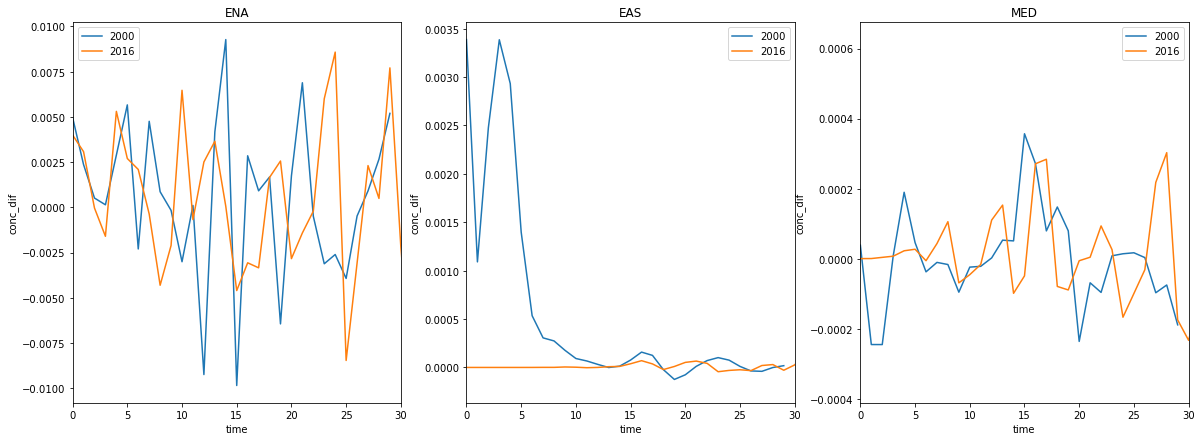

In [27]:
fig = plt.figure(figsize=(20,7))
for idx, r in enumerate(['ENA','EAS','MED']):
    ax = fig.add_subplot(1,3,idx+1)
    for idx, year in enumerate(years):
        GC_out[year][r].plot(label = year, ax = ax)
        plt.legend()
        plt.title(r)
        plt.xlim(0,30)
#plt.savefig('figures/regions_years_G_zoomed.png', bbox_inches = 'tight')

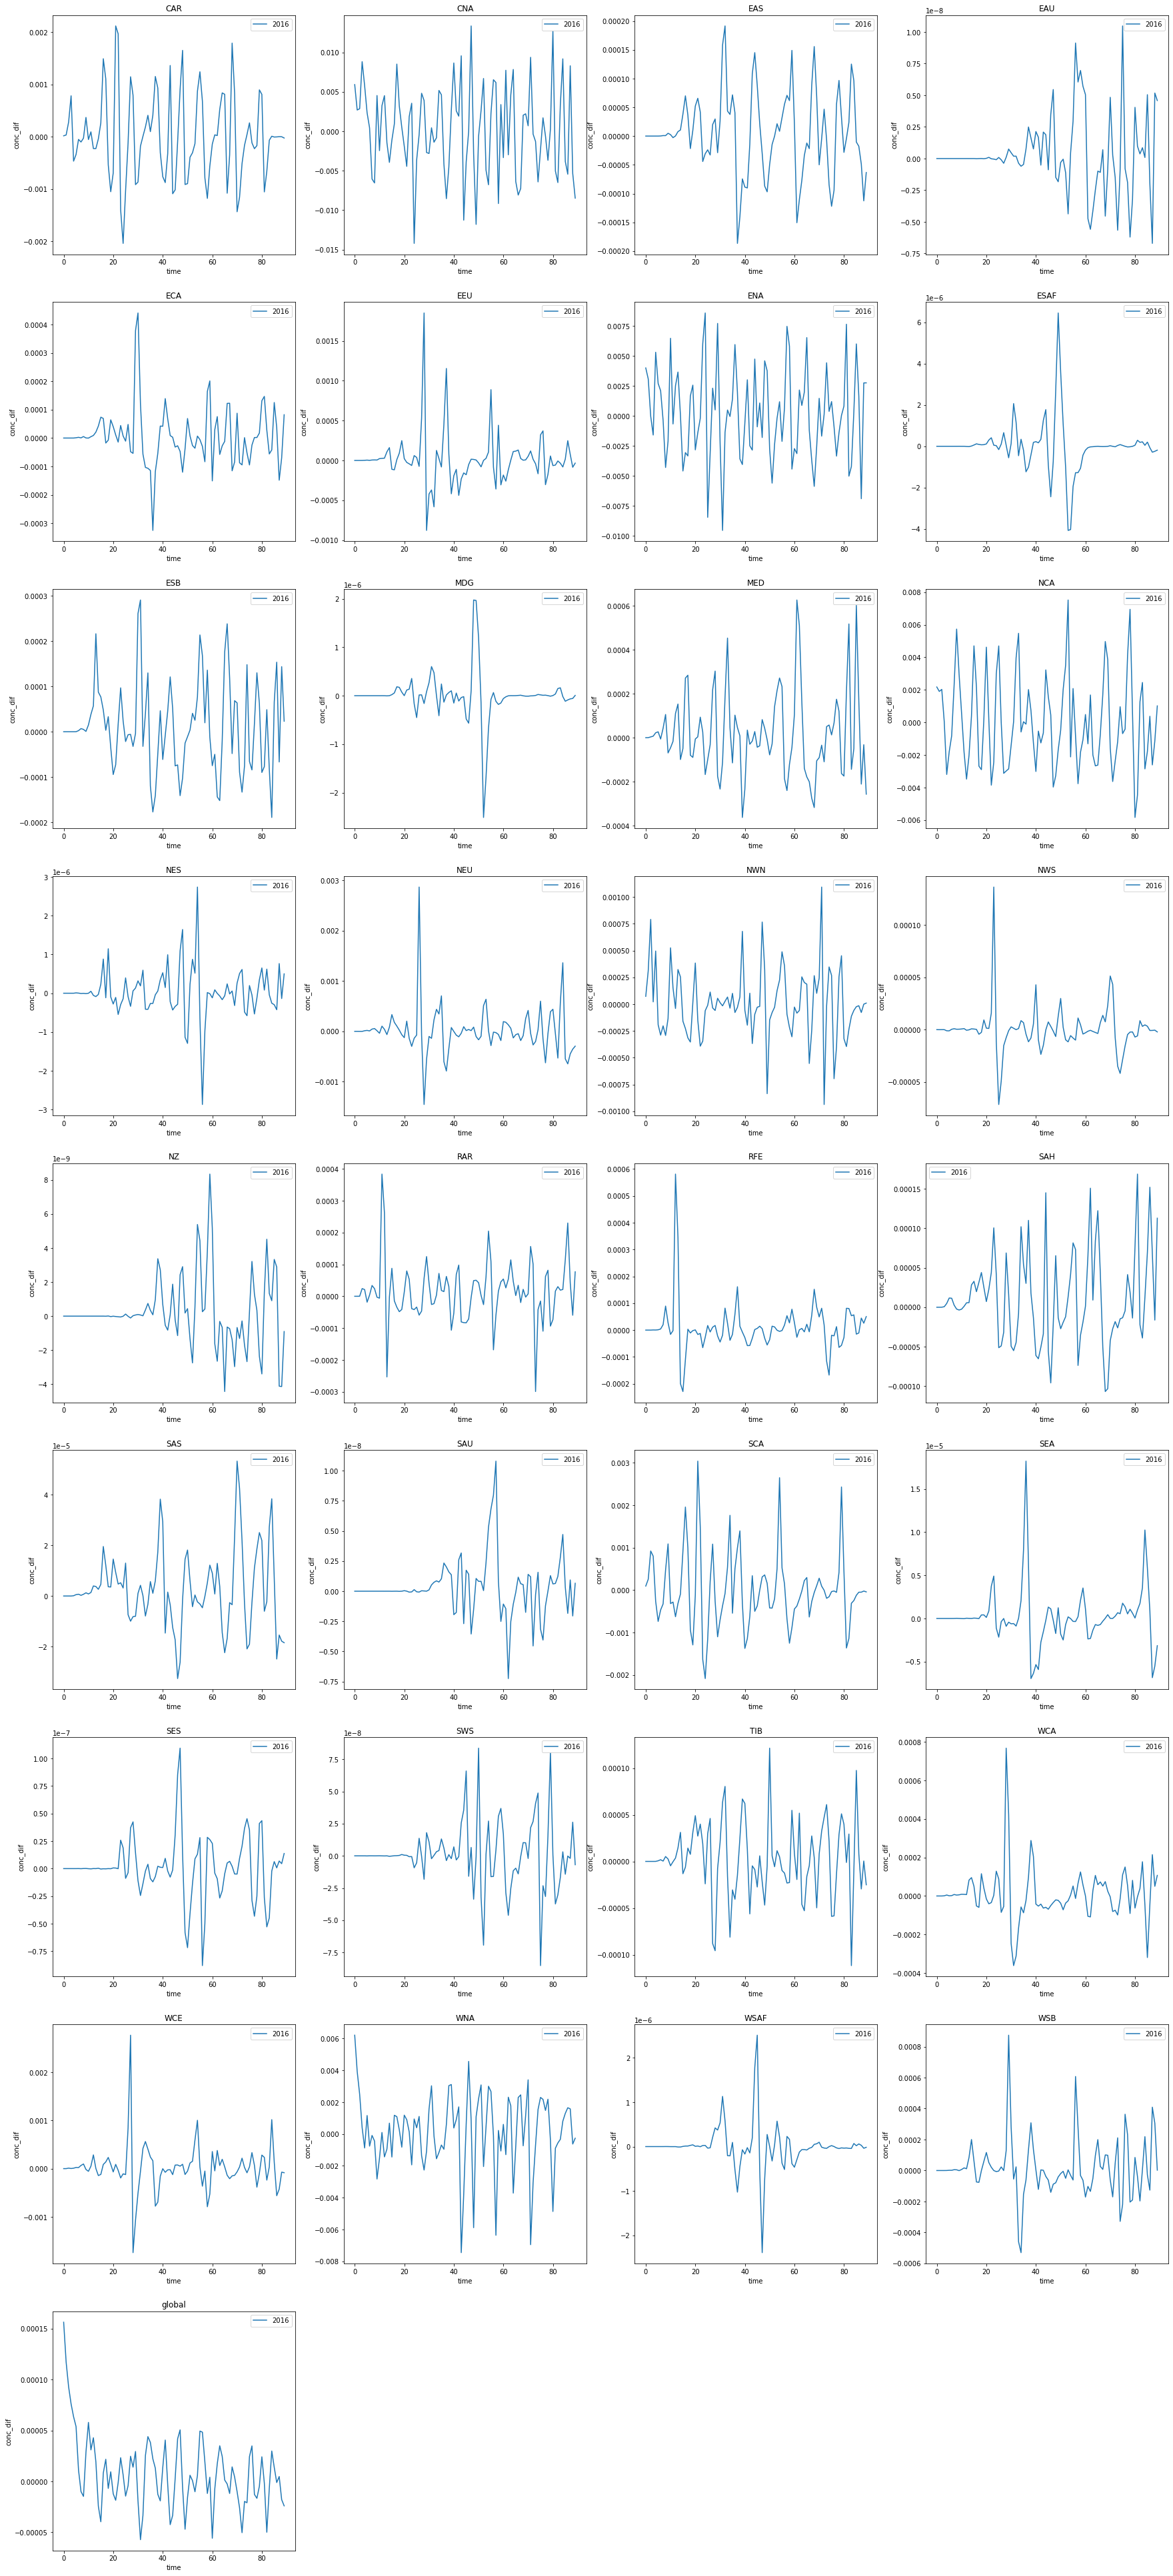

In [34]:
year = '2016'
fig = plt.figure(figsize=(30,70))
for idx, r in enumerate(full_loc):
    ax = fig.add_subplot(9,4,idx+1)
    GC_out[year][r].plot(label = year, ax = ax)
    plt.legend()
    plt.title(r)
    #plt.ylim(0.00011,0.00017)


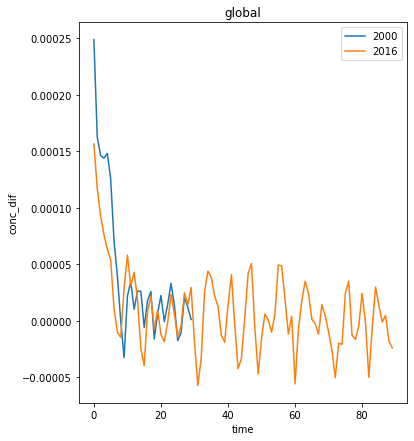

In [28]:
fig = plt.figure(figsize=(20,7))
for idx, r in enumerate(['global']):
    ax = fig.add_subplot(1,3,idx+1)
    for idx, year in enumerate(years):
        GC_out[year][r].plot(label = year, ax = ax)
        plt.legend()
        plt.title(r)
        #plt.ylim(0.00011,0.00017)
plt.savefig('figures/regions_years_G_global.png', bbox_inches = 'tight')

Text(0.5, 0.98, 'Mean of 2010 and 2016')

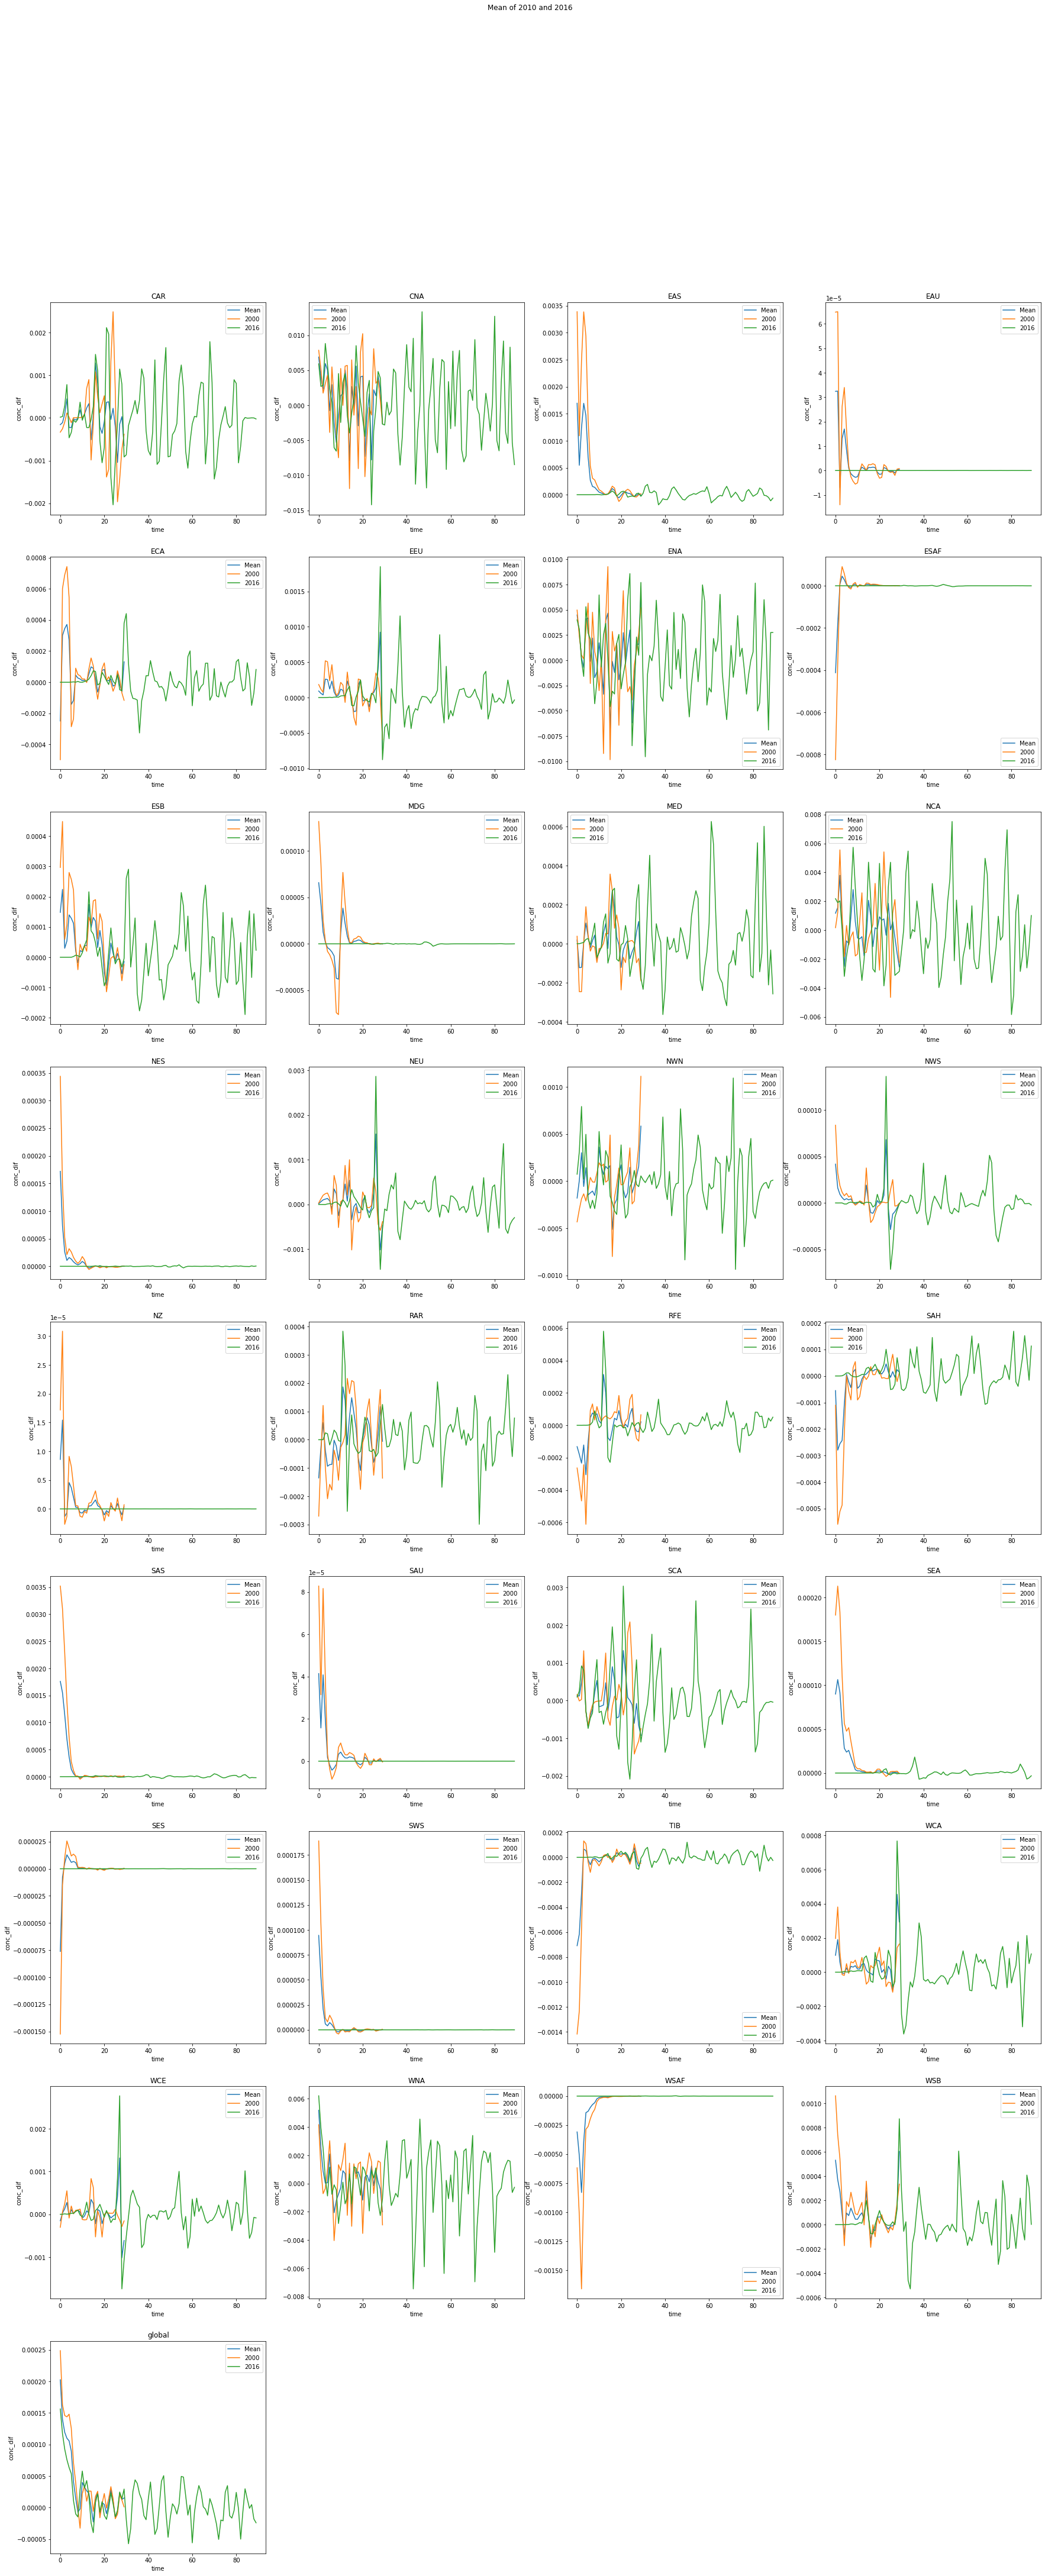

In [48]:
fig = plt.figure(figsize=(30,70))
for idx, r in enumerate(full_loc):
    ax = fig.add_subplot(9,4,idx+1)
    ((GC_out['2000'][r] + GC_out['2016'][r])/2).plot(label = 'Mean', ax = ax)
    for idx, year in enumerate(years):
        GC_out[year][r].plot(label = year, ax = ax)
    plt.legend()
    plt.title(r)
    #plt.ylim(0.00011,0.00017)
plt.suptitle('Mean of 2010 and 2016')
#plt.savefig('figures/regions_years_G.png', bbox_inches = 'tight')

Text(0.5, 0.98, 'Percent Dif Between 2010 and 2016')

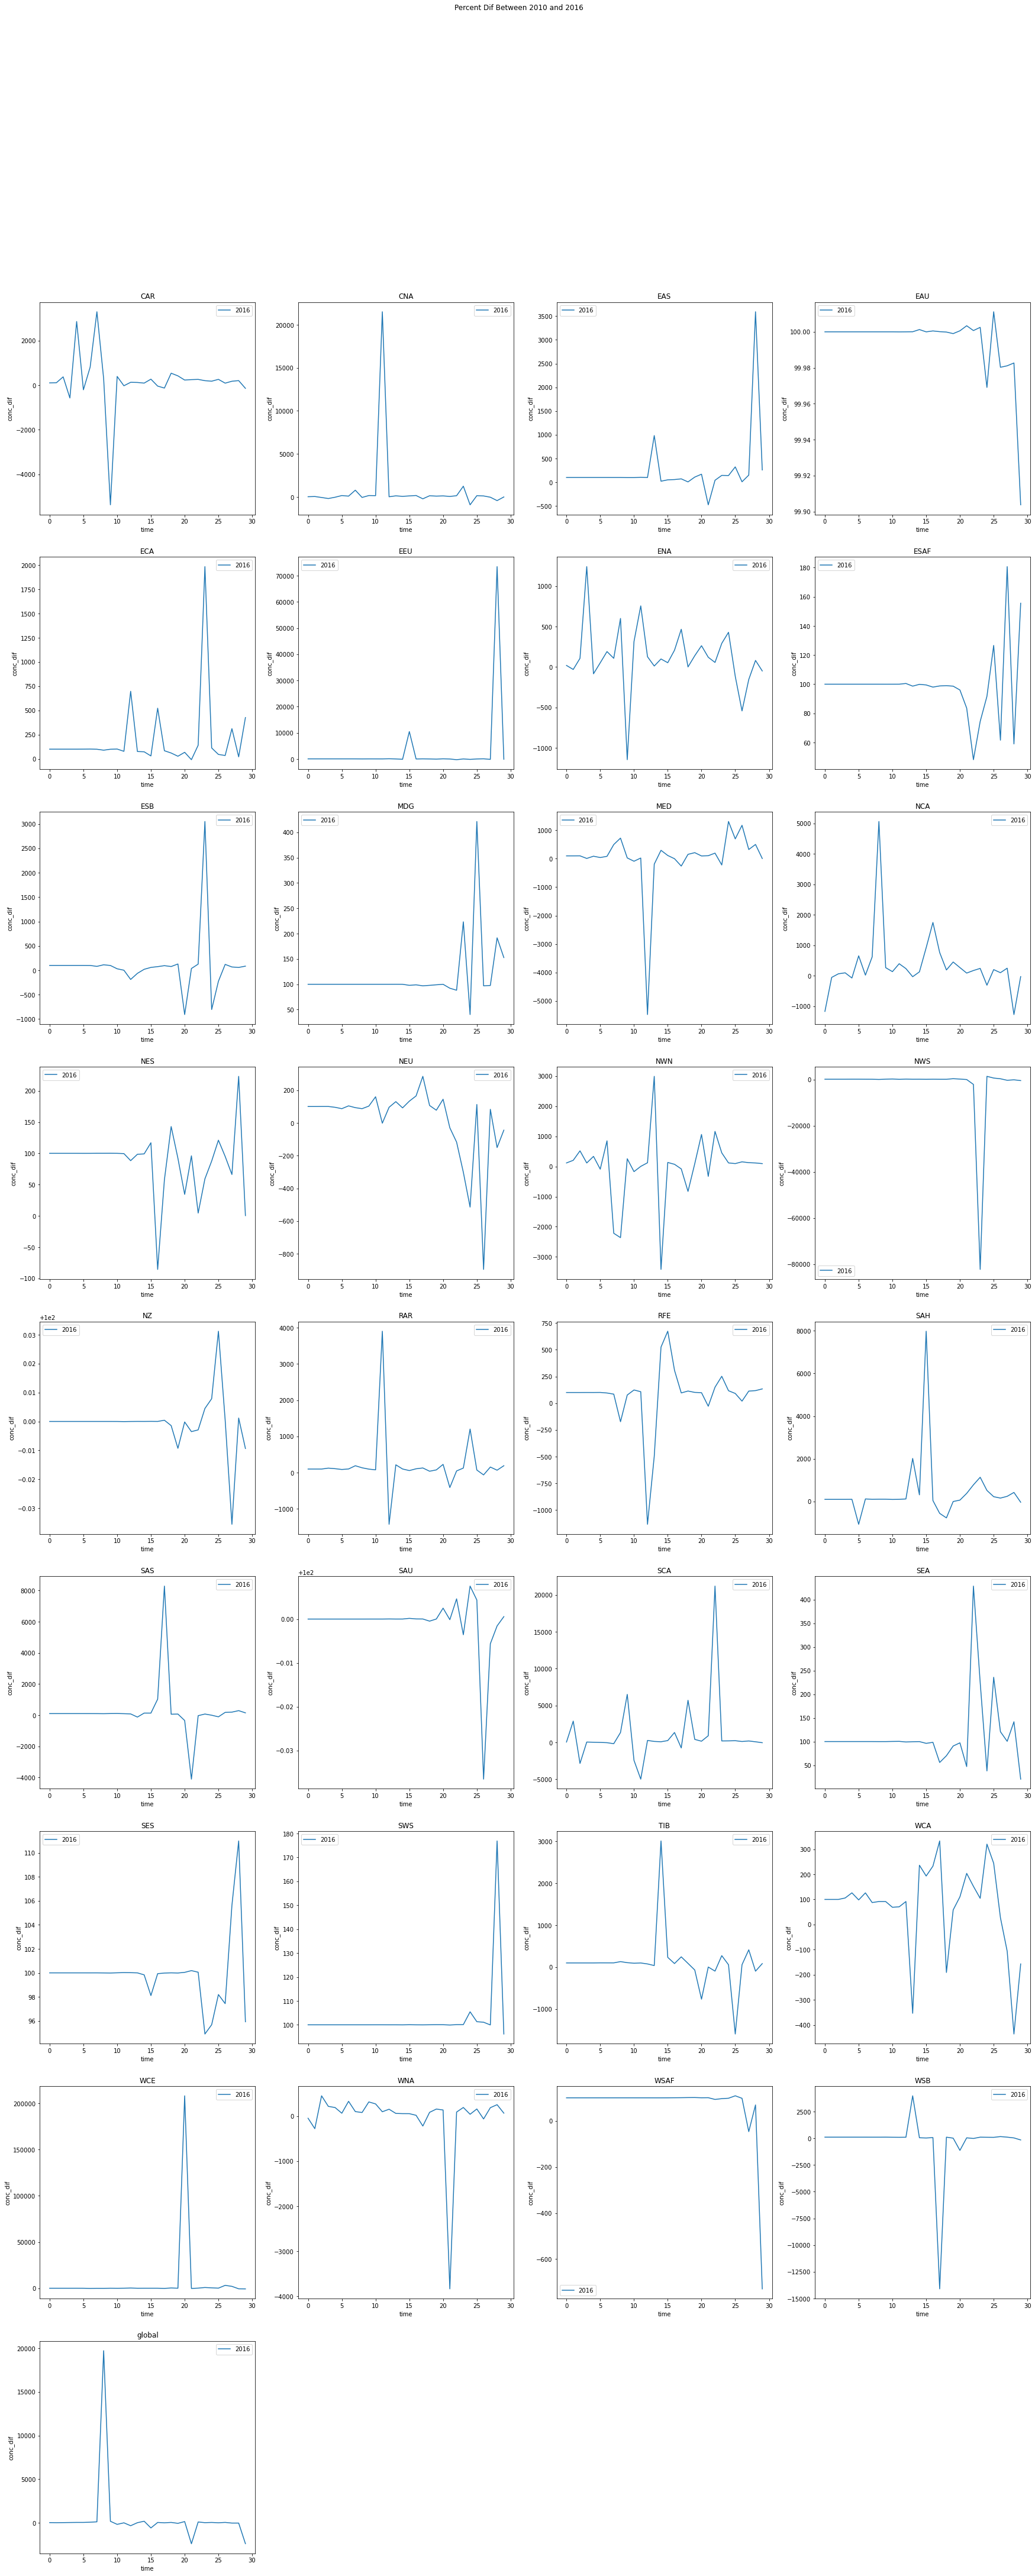

In [38]:
#Percent dif plot
fig = plt.figure(figsize=(30,70))
for idx, r in enumerate(full_loc):
    ax = fig.add_subplot(9,4,idx+1)
    (((GC_out['2000'][r]-GC_out['2016'][r])/GC_out['2000'][r])*100).plot(label = year, ax = ax)
    plt.legend()
    plt.title(r)
    #plt.ylim(0.00011,0.00017)
plt.suptitle('Percent Dif Between 2010 and 2016')
#plt.savefig('figures/regions_years_G.png', bbox_inches = 'tight')

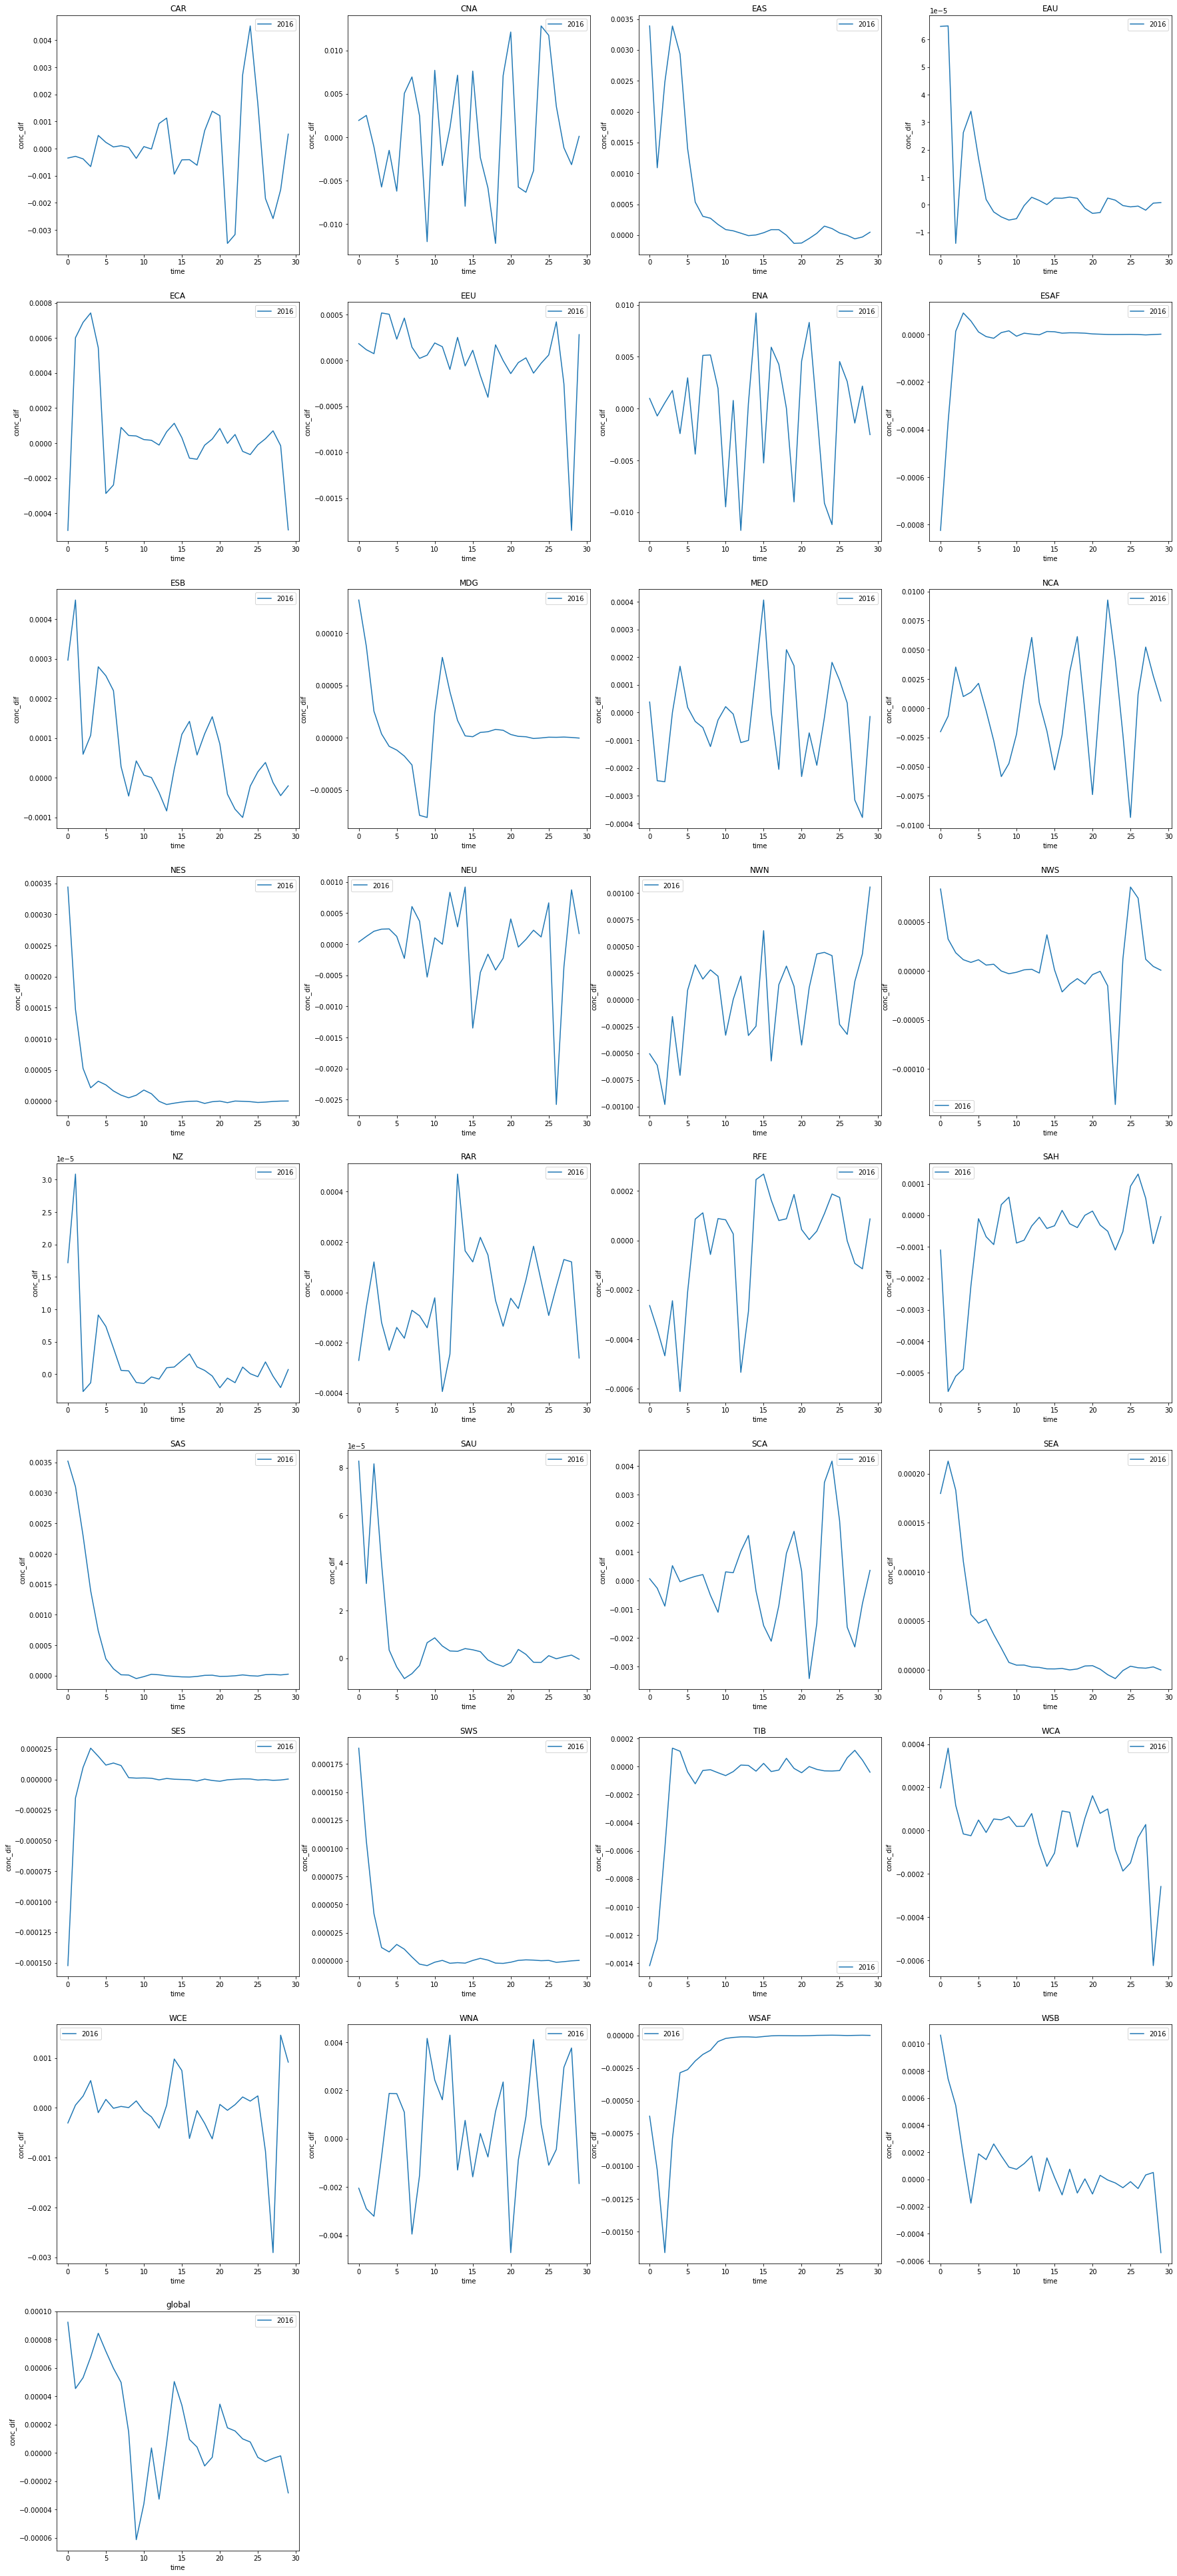

In [35]:
#dif plot
fig = plt.figure(figsize=(30,70))
for idx, r in enumerate(full_loc):
    ax = fig.add_subplot(9,4,idx+1)
    (GC_out['2000'][r]-GC_out['2016'][r]).plot(label = year, ax = ax)
    plt.legend()
    plt.title(r)
    #plt.ylim(0.00011,0.00017)
plt.savefig('figures/regions_years_G.png', bbox_inches = 'tight')

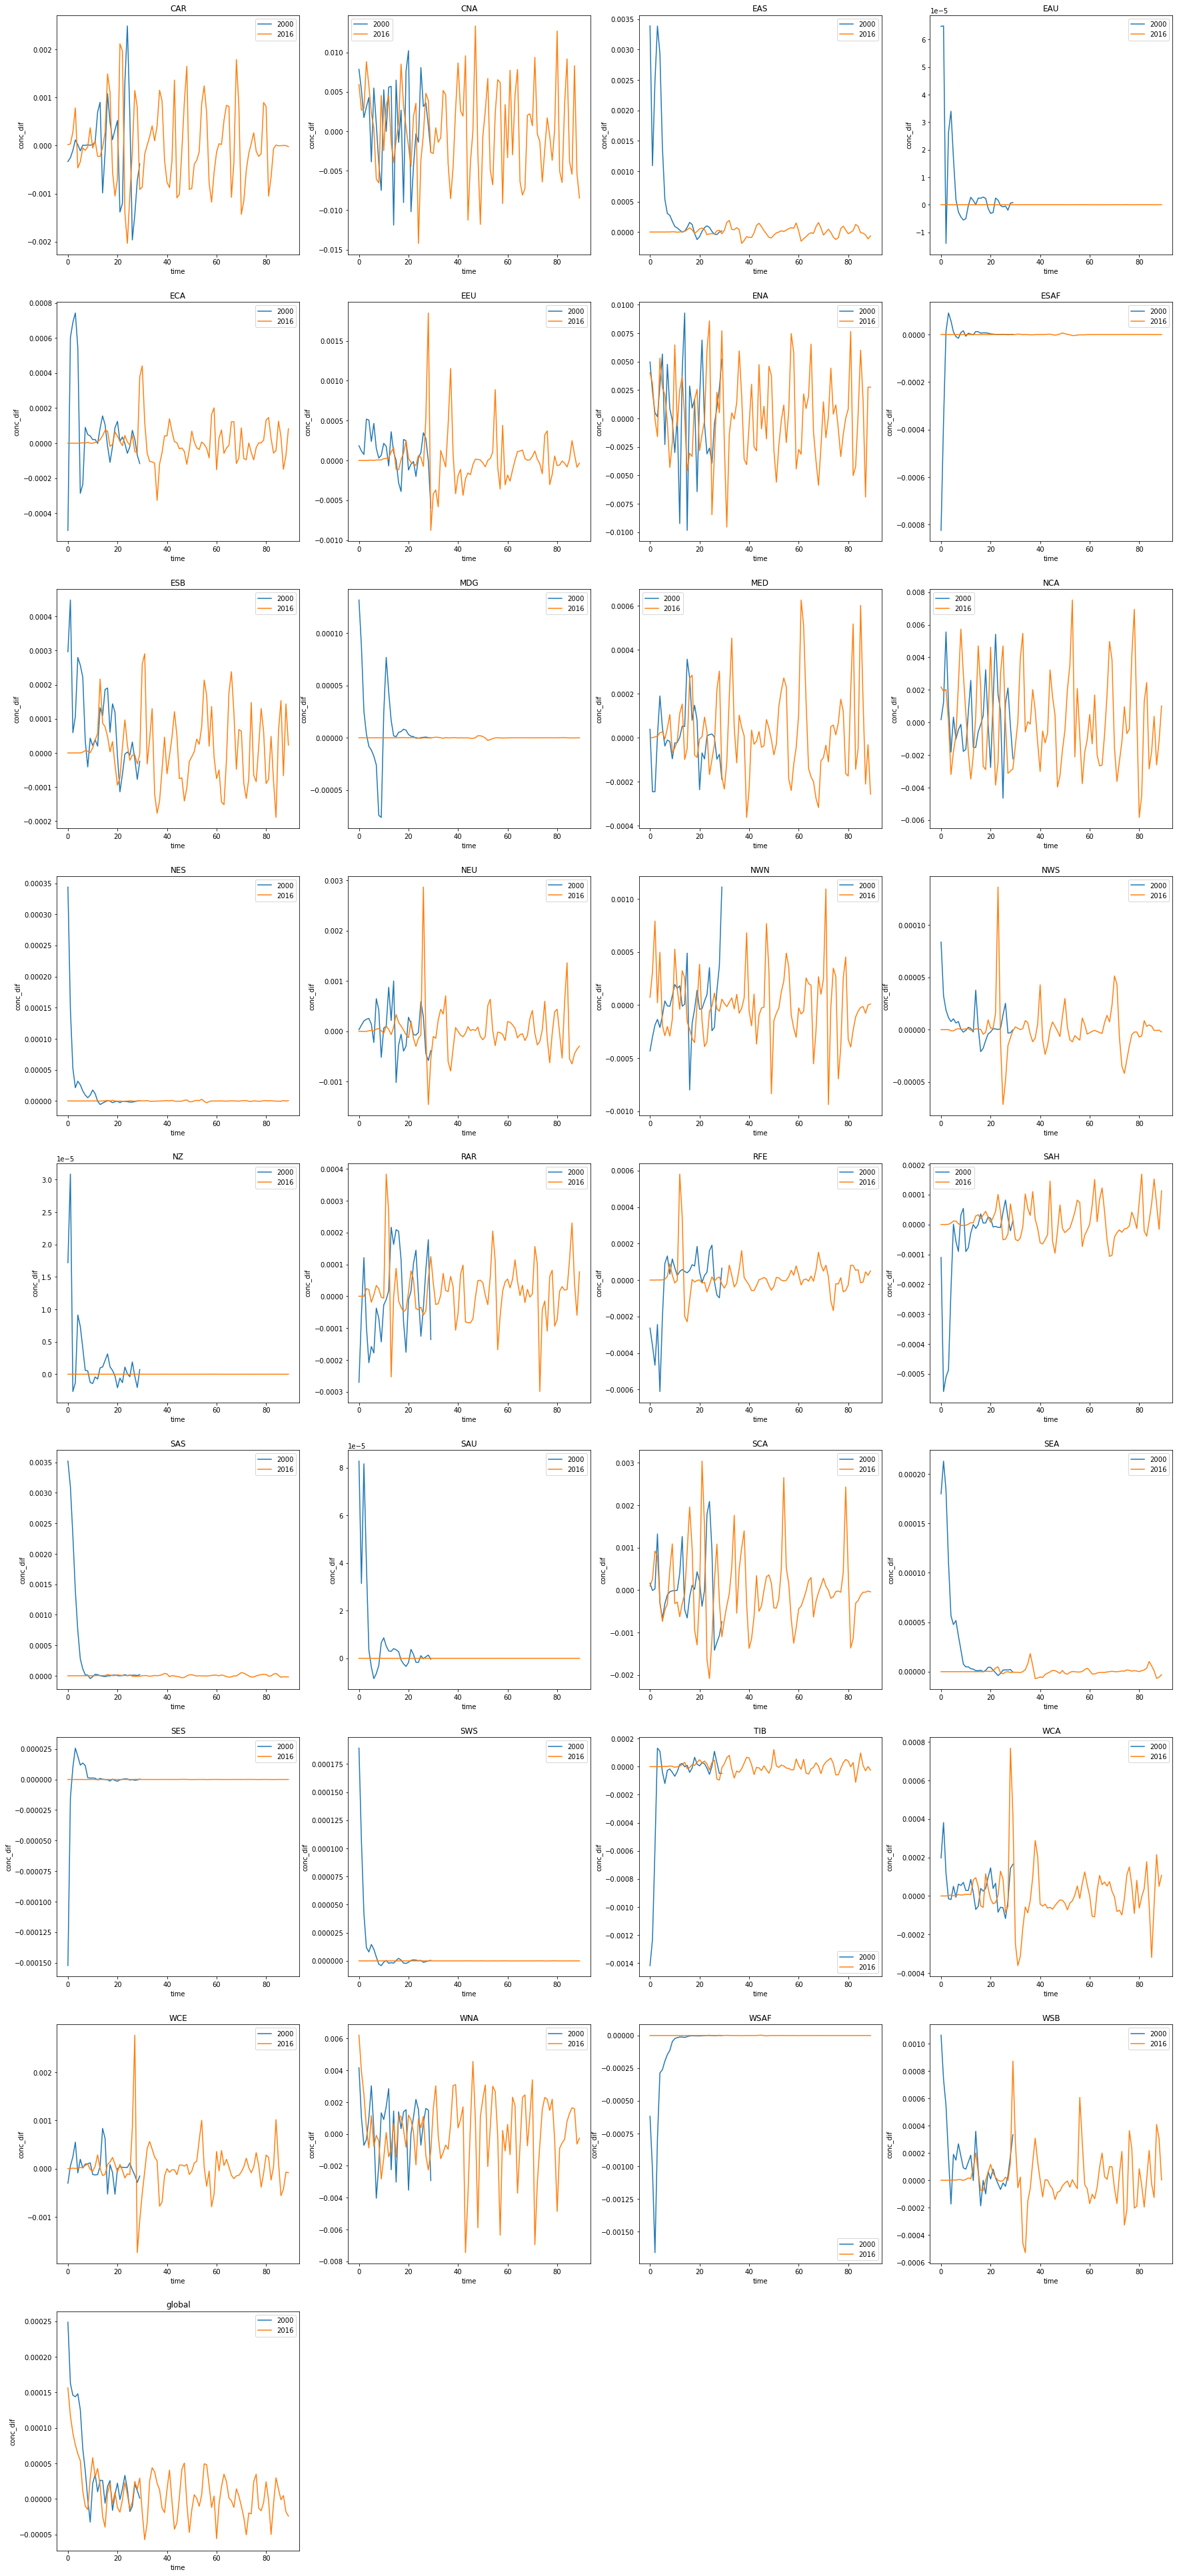

In [29]:
fig = plt.figure(figsize=(30,70))
for idx, r in enumerate(full_loc):
    ax = fig.add_subplot(9,4,idx+1)
    for idx, year in enumerate(years):
        GC_out[year][r].plot(label = year, ax = ax)
        plt.legend()
        plt.title(r)
        #plt.ylim(0.00011,0.00017)
plt.savefig('figures/regions_years_G.png', bbox_inches = 'tight')